In [3]:
#!pip install alpha_vantage
# !pip install requests
# !pip install mplfinance
!pip install pmdarima
!pip install statsmodels

     |████████████████████████████████| 1.5MB 4.5MB/s 
     |████████████████████████████████| 9.5MB 14.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [6]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


# api key: "HXFFE4IZUVLA5GEU"
# stock tests: NVDA (up) and AAL(up/down), maybe BB (down)?
data_source = 'alphavantage'
api_key = 'HXFFE4IZUVLA5GEU'

 
# set ticker to "____" & req url string respectively
ticker = "AAPL"

# obtain stock data from past 20 yrs & save as json file
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)
file_to_save = 'stock_market_data-%s.csv'%ticker  
  
# if no saved data, grab from url_string
if not os.path.exists(file_to_save):
  with urllib.request.urlopen(url_string) as url:
    data = json.loads(url.read().decode())
    
    # store date, low, high, volume, close, & open values to dataframe & save
    data = data['Time Series (Daily)']
    df = pd.DataFrame(columns = ['Date', 'Low', 'High', 'Close', 'Open'])
    for k,v in data.items():
      date = dt.datetime.strptime(k, '%Y-%m-%d')
      data_row = [date.date(), float(v['3. low']), float(v['2. high']), 
                  float(v['4. close']), float(v['1. open'])]
      df.loc[-1,:] = data_row
      df.index = df.index+1
  print('Data saved to : %s'%file_to_save)        
  df.to_csv(file_to_save)
else:
  #if existing, grab from csv
  print('Existing file found, loading data from CSV.')
  df = pd.read_csv(file_to_save)


Existing file found, loading data from CSV.


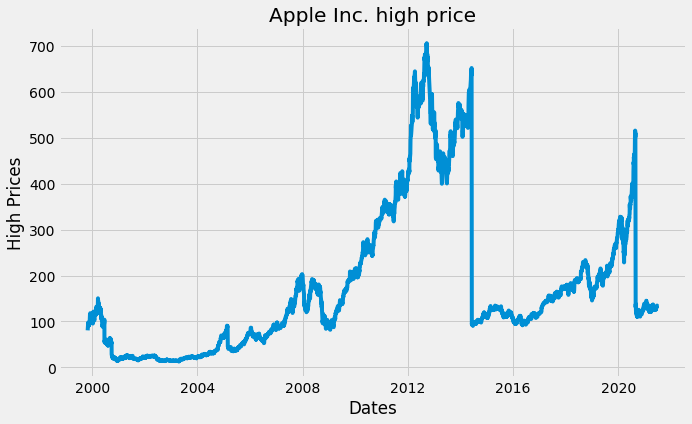

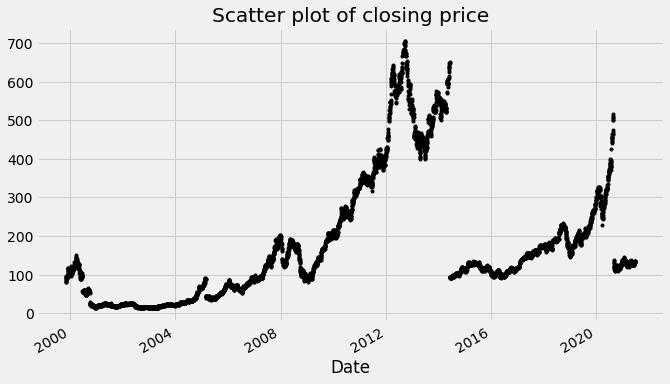

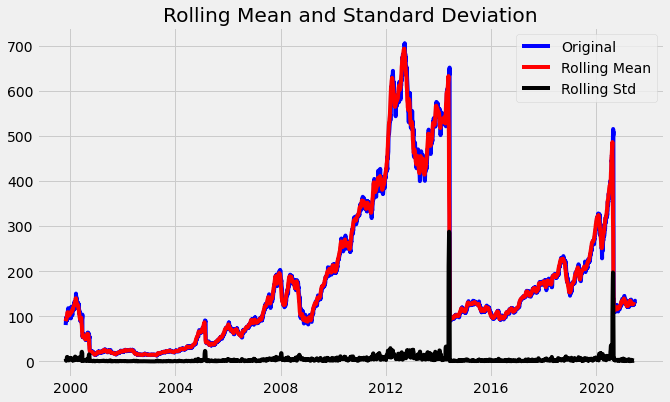

Results of dickey fuller test
Test Statistics                  -2.272302
p-value                           0.181057
No. of lags used                  0.000000
Number of observations used    5447.000000
critical value (1%)              -3.431551
critical value (5%)              -2.862071
critical value (10%)             -2.567053
dtype: float64


No handles with labels found to put in legend.


<Figure size 720x432 with 0 Axes>

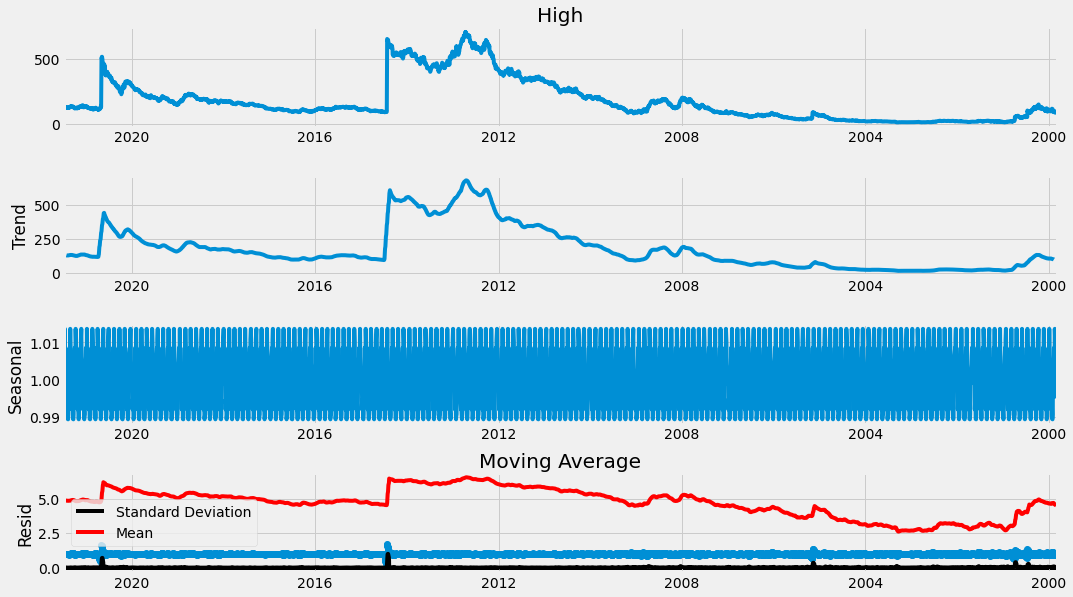

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np



dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv(file_to_save,sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)


#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('High Prices')
plt.plot(data['High'])
plt.title('Apple Inc. high price')
plt.show()



df_close = data['High']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()




#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)


result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)


from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()



In [4]:
#split data into train and training set
train_data, test_data = df_log[int(len(df_log)*0.1):], df_log[3:int(len(df_log)*0.1)]
'''
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
'''



model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())


'''
How to interpret the plot diagnostics?

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. 
Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. 
Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. 
So you will need to look for more X’s (predictors) to the model.
'''
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()



model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18089.686, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18089.811, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18089.778, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18091.567, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18088.246, Time=1.92 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.462 seconds


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local

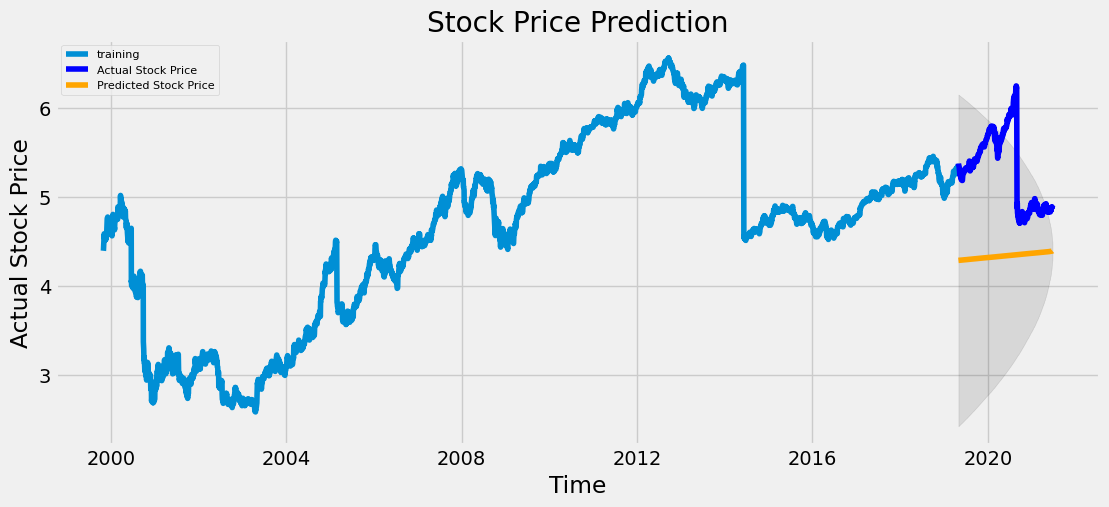

MSE: 1.1516846263249032
MAE: 0.9794000697521382
RMSE: 1.0731657031068889
MAPE: 0.17890687710428266


In [5]:
# Forecast
fc, se, conf = fitted.forecast(541, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

#plot results and findings
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()




#judge results
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))